In [ ]:
# Installing the required libraries
!pip install folium --upgrade
!pip install folium.plugins

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0


ERROR: Could not find a version that satisfies the requirement folium.plugins (from versions: none)
ERROR: No matching distribution found for folium.plugins


In [ ]:
# Importing all the necessary libraries

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import geopandas as gpd
from operator import itemgetter
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster
from matplotlib.cm import viridis
from matplotlib.colors import to_rgba, Normalize
from matplotlib import cm
from matplotlib.cm import get_cmap
import collections

In [ ]:
# Loading the Helsinki City Bike dataset into a DataFrame called 'bike_data'
bike_data = pd.read_csv('database.csv',low_memory=False)

In [ ]:
# Displaying data
bike_data.head()

departure               return  departure_id    departure_name  \
0  2020-03-23 06:09:44  2020-03-23 06:16:26            86          Kuusitie   
1  2020-03-23 06:11:58  2020-03-23 06:26:31            26        Kamppi (M)   
2  2020-03-23 06:16:29  2020-03-23 06:24:23           268  Porolahden koulu   
3  2020-03-23 06:33:53  2020-03-23 07:14:03           751        Vallipolku   
4  2020-03-23 06:36:09  2020-03-23 07:04:10            62  Länsisatamankatu   

   return_id       return_name  distance (m)  duration (sec.)  \
0      111.0     Esterinportti        1747.0            401.0   
1       10.0       Kasarmitori        1447.0            869.0   
2      254.0       Agnetankuja        1772.0            469.0   
3      106.0   Korppaanmäentie        7456.0           2406.0   
4      121.0  Vilhonvuorenkatu        7120.0           1679.0   

   avg_speed (km/h)  departure_latitude  departure_longitude  return_latitude  \
0          0.261397           60.195245            24.901900        60.197572   
1          0.099908           60.168610            24.930537        60.165017   
2          0.226695           60.195540            25.053581        60.187234   
3          0.185935           60.227827            24.819614        60.203474   
4          0.254437           60.158928            24.909692        60.186463   

   return_longitude  Air temperature (degC)  
0         24.926781                     0.9  
1         24.949473                     0.9  
2         25.036412                     0.9  
3         24.898930                     0.9  
4         24.967872                     0.9

In [ ]:
# Displaying total dataset to find out the missing values
print("Initial dataset info:")
print(bike_data.info())


Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89733 entries, 0 to 89732
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   departure               89733 non-null  object 
 1   return                  89733 non-null  object 
 2   departure_id            89733 non-null  int64  
 3   departure_name          89733 non-null  object 
 4   return_id               89733 non-null  float64
 5   return_name             89733 non-null  object 
 6   distance (m)            89733 non-null  float64
 7   duration (sec.)         89733 non-null  float64
 8   avg_speed (km/h)        89714 non-null  float64
 9   departure_latitude      89733 non-null  float64
 10  departure_longitude     89732 non-null  float64
 11  return_latitude         89732 non-null  float64
 12  return_longitude        89732 non-null  float64
 13  Air temperature (degC)  89732 non-null  float64
dtypes: float64(9), i

In [ ]:
# Checking for duplicate rows
duplicate_rows = bike_data.duplicated()

In [ ]:
# Displaying the rows that are duplicates
duplicate_data = bike_data[duplicate_rows]
print("Duplicate Rows:")
print(duplicate_data)

Duplicate Rows:
                 departure               return  departure_id  \
40315  2020-03-31 17:43:08  2020-03-31 17:43:28           239   

           departure_name  return_id         return_name  distance (m)  \
40315  Viikin tiedepuisto      239.0  Viikin tiedepuisto           0.0   

       duration (sec.)  avg_speed (km/h)  departure_latitude  \
40315             16.0               0.0           60.227521   

       departure_longitude  return_latitude  return_longitude  \
40315            25.010062        60.227521         25.010062   

       Air temperature (degC)  
40315                    -0.2  


In [ ]:
# Count the number of duplicate rows
num_duplicates = duplicate_data.shape[0]
print(f"\nNumber of Duplicate Rows: {num_duplicates}")


Number of Duplicate Rows: 1


In [ ]:
# Droping duplicate rows from a dataset
bike_data = bike_data.drop_duplicates()

In [ ]:
# Renaming the column name
bike_data[['departure','return']] =  bike_data[['departure','return']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

bike_data = bike_data.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'average_speed',
                                      'Air temperature (degC)':'temperature',
                                     })
bike_data = bike_data[
                    (50 < bike_data['distance']) & (bike_data['distance'] < 10000) &
                    (120 < bike_data['duration']) & (bike_data['duration'] <  18000) &
                    (-20 < bike_data['temperature']) & (bike_data['temperature'] < 50)
                    ]

In [ ]:
# Displaying data
bike_data.head()

departure              return  departure_id    departure_name  \
0 2020-03-23 06:09:44 2020-03-23 06:16:26            86          Kuusitie   
1 2020-03-23 06:11:58 2020-03-23 06:26:31            26        Kamppi (M)   
2 2020-03-23 06:16:29 2020-03-23 06:24:23           268  Porolahden koulu   
3 2020-03-23 06:33:53 2020-03-23 07:14:03           751        Vallipolku   
4 2020-03-23 06:36:09 2020-03-23 07:04:10            62  Länsisatamankatu   

   return_id       return_name  distance  duration  average_speed  \
0      111.0     Esterinportti    1747.0     401.0       0.261397   
1       10.0       Kasarmitori    1447.0     869.0       0.099908   
2      254.0       Agnetankuja    1772.0     469.0       0.226695   
3      106.0   Korppaanmäentie    7456.0    2406.0       0.185935   
4      121.0  Vilhonvuorenkatu    7120.0    1679.0       0.254437   

   departure_latitude  departure_longitude  return_latitude  return_longitude  \
0           60.195245            24.901900        60.197572         24.926781   
1           60.168610            24.930537        60.165017         24.949473   
2           60.195540            25.053581        60.187234         25.036412   
3           60.227827            24.819614        60.203474         24.898930   
4           60.158928            24.909692        60.186463         24.967872   

   temperature  
0          0.9  
1          0.9  
2          0.9  
3          0.9  
4          0.9

In [ ]:
# Displaying total dataset to find out the missing values
print("Initial dataset info:")
print(bike_data.info())

Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79797 entries, 0 to 89731
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   departure            79797 non-null  datetime64[ns]
 1   return               79797 non-null  datetime64[ns]
 2   departure_id         79797 non-null  int64         
 3   departure_name       79797 non-null  object        
 4   return_id            79797 non-null  float64       
 5   return_name          79797 non-null  object        
 6   distance             79797 non-null  float64       
 7   duration             79797 non-null  float64       
 8   average_speed        79797 non-null  float64       
 9   departure_latitude   79797 non-null  float64       
 10  departure_longitude  79797 non-null  float64       
 11  return_latitude      79797 non-null  float64       
 12  return_longitude     79797 non-null  float64       
 13  temperatu

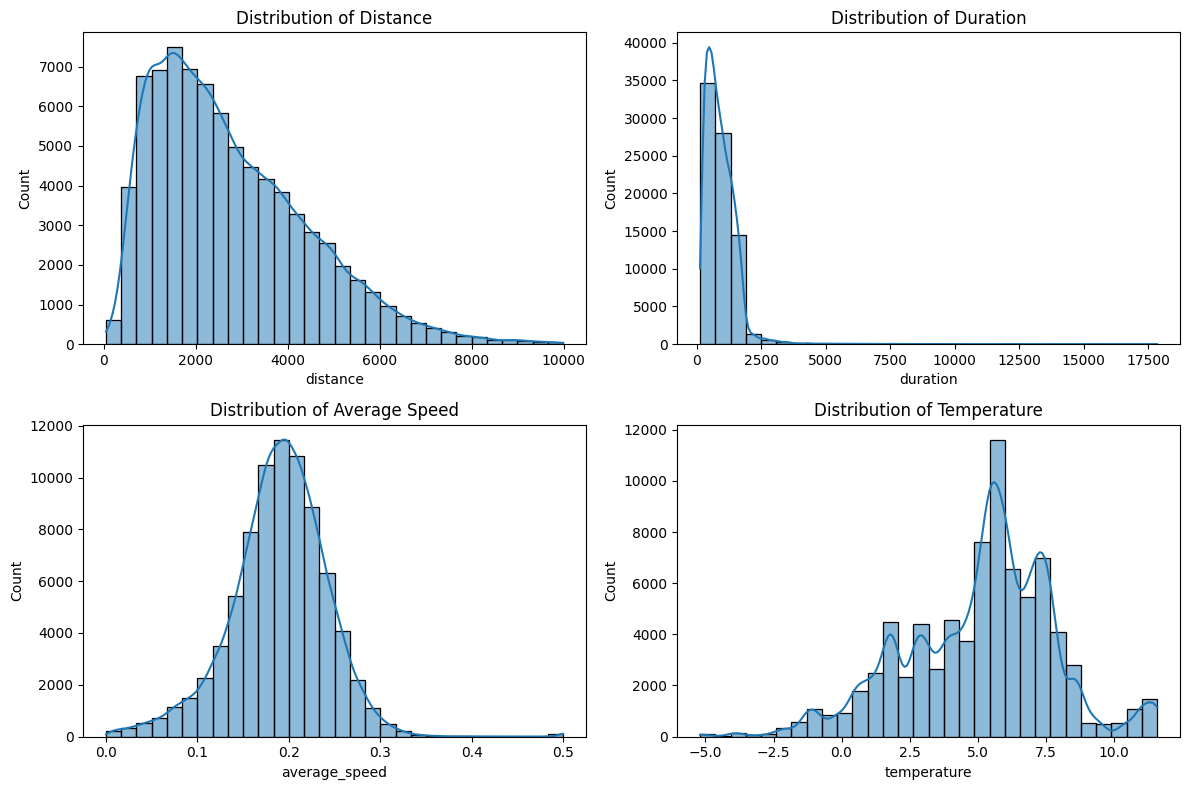

In [ ]:
# Distribution of key variables
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(bike_data['distance'], bins=30, kde=True)
plt.title('Distribution of Distance')

plt.subplot(2, 2, 2)
sns.histplot(bike_data['duration'], bins=30, kde=True)
plt.title('Distribution of Duration')

plt.subplot(2, 2, 3)
sns.histplot(bike_data['average_speed'], bins=30, kde=True)
plt.title('Distribution of Average Speed')

plt.subplot(2, 2, 4)
sns.histplot(bike_data['temperature'], bins=30, kde=True)
plt.title('Distribution of Temperature')

plt.tight_layout()
plt.show()

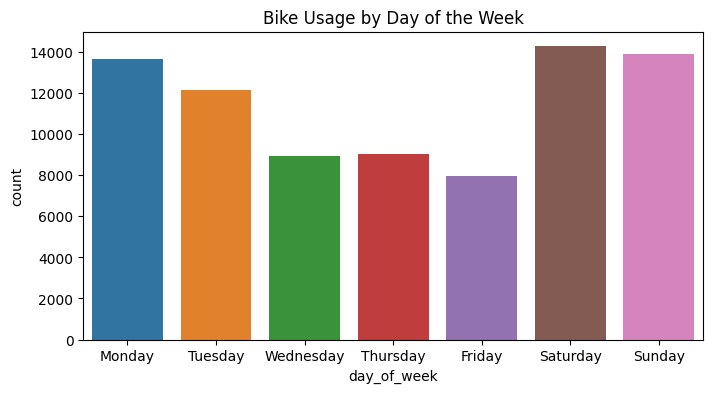

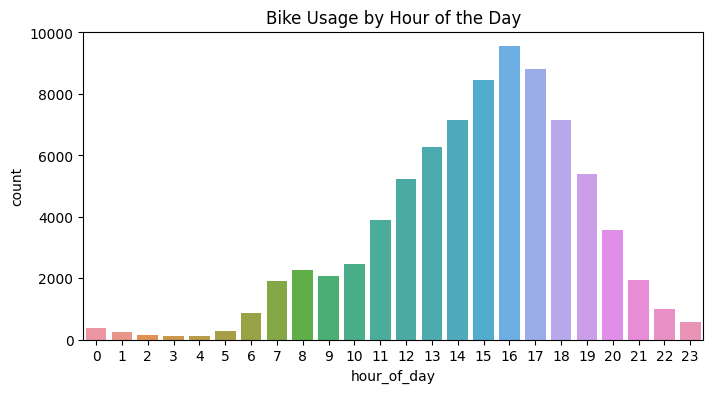

In [ ]:
# Extract features from datetime columns
date_time_df = bike_data.copy()
date_time_df['day_of_week'] = date_time_df['departure'].dt.day_name()
date_time_df['hour_of_day'] = date_time_df['departure'].dt.hour

# Bike usage by day of the week
plt.figure(figsize=(8, 4))
sns.countplot(x='day_of_week', data=date_time_df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Bike Usage by Day of the Week')
plt.show()

# Bike usage by hour of the day
plt.figure(figsize=(8, 4))
sns.countplot(x='hour_of_day', data=date_time_df)
plt.title('Bike Usage by Hour of the Day')
plt.show()

<ipython-input-24-be1e199bf80c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = bike_data.corr()


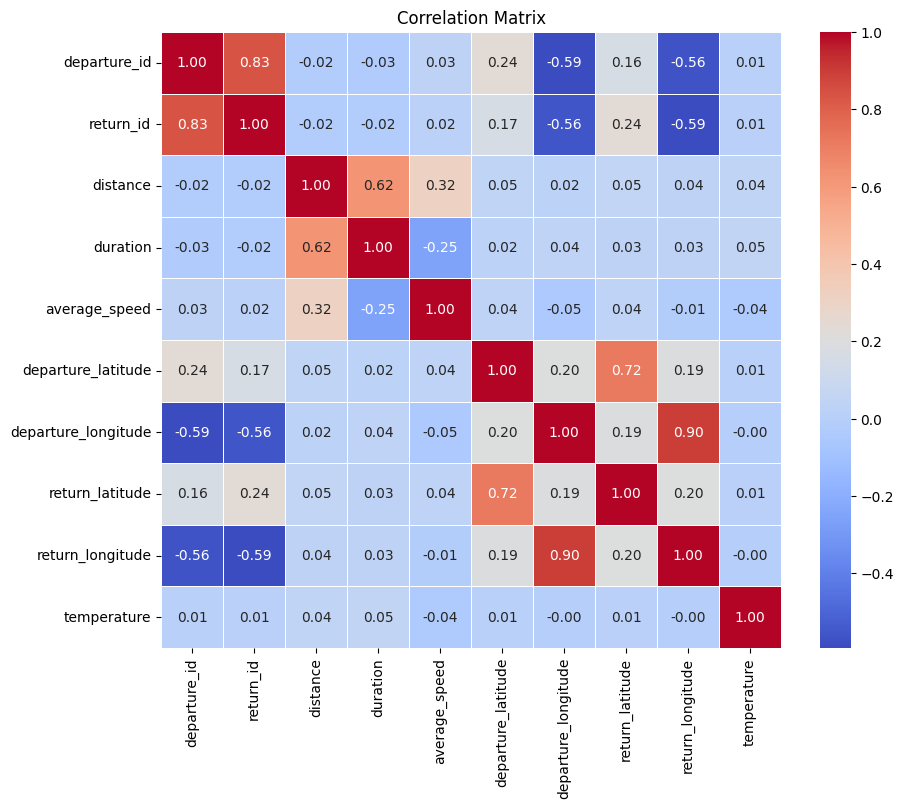

In [ ]:
# Correlation Analysis

correlation_matrix = bike_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

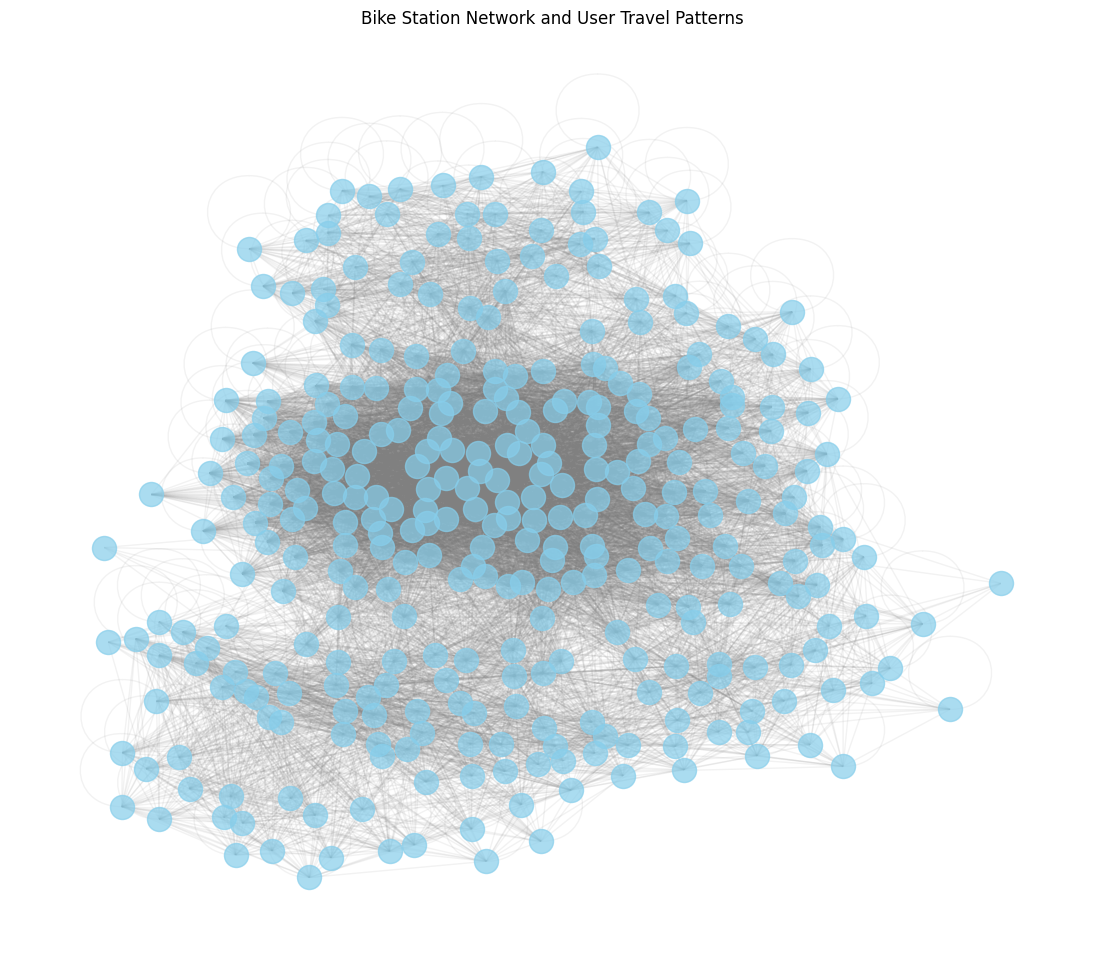

In [ ]:
# Bike Station Network and User Travel Patterns
def visualize_bike_network(bike_data):

    # Saving dataset in new variable df
    df = bike_data.copy()

    # Creating a directed graph
    G = nx.DiGraph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

    # Visualization of the bike station network
    plt.figure(figsize=(14, 12))

    # Positioning of nodes using the Kamada-Kawai layout for better spacing
    pos = nx.kamada_kawai_layout(G)

    # Draw nodes with adjusted node sizes
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.7)

    # Draw edges with lighter color
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray', arrows=False)

    # Label nodes with larger font size
    nx.draw_networkx_labels(G, pos, labels={}, font_size=10, font_color='black')

    plt.title('Bike Station Network and User Travel Patterns')
    plt.axis('off')
    plt.show()

    return G

# calling a function visualize_bike_network
G = visualize_bike_network(bike_data)

In [ ]:
# Additional network statistics for the Helsinki City bike network

def additionalNetworkStats(G):

    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

    # Calculate and print average degree
    average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    print("Average degree:", average_degree)

    # Print maximum and minimum degrees
    max_degree_node = max(G.degree(), key=itemgetter(1))
    min_degree_node = min(G.degree(), key=itemgetter(1))
    print(f"\nNode with Maximum Degree: {max_degree_node}")
    print(f"Node with Minimum Degree: {min_degree_node}")


    density = nx.density(G)
    print("\nNetwork density:", density)

    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for node, degree in sorted_degree[:5]:
        print(f"('{node}', {degree})")

    # Compute betweenness centrality
    betweenness_dict = nx.betweenness_centrality(G)
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    # Compute eigenvector centrality
    eigenvector_dict = nx.eigenvector_centrality(G)
    sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)


    # Displaying top 5 nodes by betweenness centrality
    print("\nTop 5 nodes by betweenness centrality:\n")
    for node, betweenness in sorted_betweenness[:5]:
         print(f"Node: {node}, Betweenness Centrality: {betweenness}")

    # Displaying top 5 nodes by eigenvector centrality
    print("\nTop 5 nodes by eigenvector centrality :\n")
    for node, eigenvector in sorted_eigenvector[:5]:
        print(f"Node: {node}, Eigenvector Centrality: {eigenvector}")

# Call the additionalNetworkStats function
additionalNetworkStats(G)

Number of nodes: 334
Number of edges: 12989
Average degree: 77.77844311377245

Node with Maximum Degree: ('Kalasatama (M)', 173)
Node with Minimum Degree: ('Sateentie', 6)

Network density: 0.23356889823955693
Triadic closure: 0.5951919415269332

Top 5 nodes by degree:

('Kalasatama (M)', 173)
('Ympyrätalo', 166)
('Itämerentori', 157)
('Pasilan asema', 157)
('Messeniuksenkatu', 156)

Top 5 nodes by betweenness centrality:

Node: Haukilahdenkatu, Betweenness Centrality: 0.07792269356771589
Node: Kalasatama (M), Betweenness Centrality: 0.02421085444827892
Node: Kulosaari (M), Betweenness Centrality: 0.015520461623667048
Node: Laajalahden aukio, Betweenness Centrality: 0.01441618337193202
Node: Aalto-yliopisto (M), Korkeakouluaukio, Betweenness Centrality: 0.014168468620836584

Top 5 nodes by eigenvector centrality :

Node: Ympyrätalo, Eigenvector Centrality: 0.10950098757074271
Node: Brahen kenttä, Eigenvector Centrality: 0.10446011186004893
Node: Ooppera, Eigenvector Centrality: 0.10379

Mean Squared Error: 613463.211163652


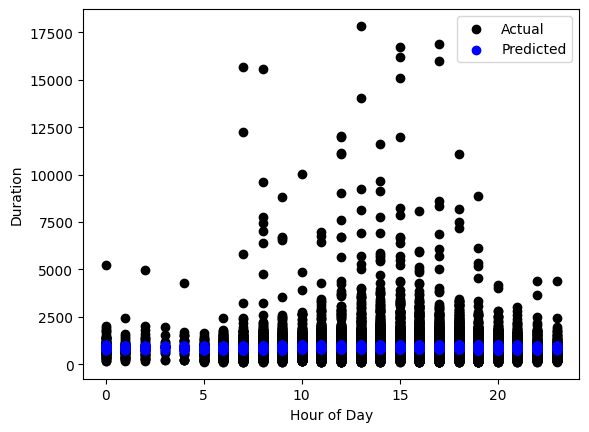

In [ ]:
# Feature engineering
pred_act_values = bike_data.copy()
pred_act_values['day_of_week'] = pred_act_values['departure'].dt.dayofweek
pred_act_values['hour_of_day'] = pred_act_values['departure'].dt.hour

# Select features and target variable
features = ['day_of_week', 'hour_of_day', 'temperature']
target = 'duration'

X = pred_act_values[features]
y = pred_act_values[target]

# Spliting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
predictions = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Visualizing the predictions vs. actual values
plt.scatter(X_test['hour_of_day'], y_test, color='black', label='Actual')
plt.scatter(X_test['hour_of_day'], predictions, color='blue', label='Predicted')
plt.xlabel('Hour of Day')
plt.ylabel('Duration')
plt.legend()
plt.show()

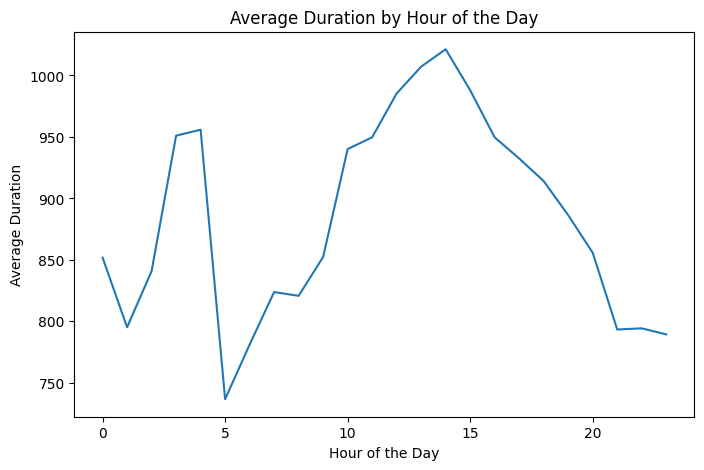

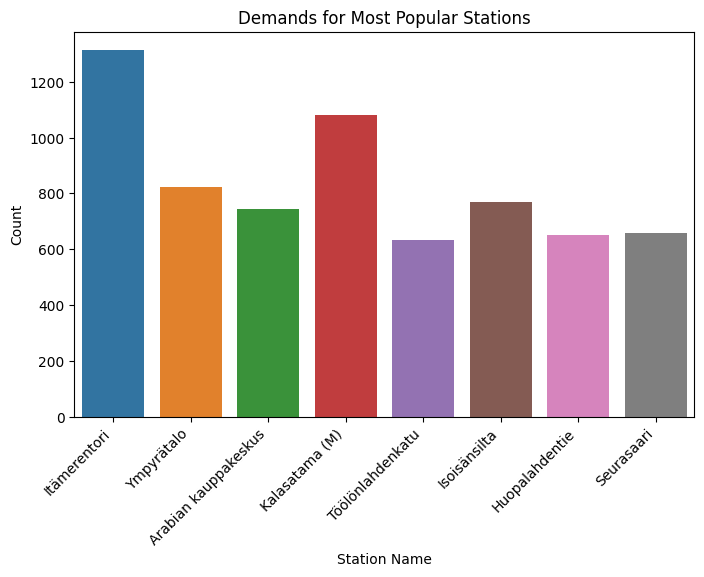

In [ ]:
# Visualizing average duration by hour of the day
plt.figure(figsize=(8,5))
sns.lineplot(x='hour_of_day', y='duration', data=date_time_df, errorbar=None)
plt.title('Average Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Duration')
plt.show()

# Calculating station frequencies
station_frequencies = bike_data['departure_name'].value_counts()

# Selecting the top 8 most popular stations
top = 8
top_stations = station_frequencies.nlargest(top)

# Filtering the dataframe to include only data for the top stations
top_station_data = bike_data[bike_data['departure_name'].isin(top_stations.index)]

# Visualizing demands for the most popular stations
plt.figure(figsize=(8, 5))
sns.countplot(x='departure_name', data=top_station_data)
plt.title('Demands for Most Popular Stations')
plt.xlabel('Station Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()



In [ ]:
# Displaying geospatial visualization
def generate_bubble_plot(dataframe):

    # Drop rows with missing values
    dataframe.dropna(inplace=True)

    # Calculate frequencies for each departure station
    dataframe['freq'] = dataframe.groupby('departure_name')['departure_name'].transform('count')

    # Create a DataFrame with unique station names and their frequencies
    df_stations = dataframe[['departure_name', 'freq']].drop_duplicates(subset=['departure_name']).reset_index(drop=True)

    # Load station coordinates data
    station_coordinates_url = "https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv"
    df_station_coordinates = pd.read_csv(station_coordinates_url, index_col=False)

    # Filter stations with latitude <= 60.254011
    df_station_coordinates = df_station_coordinates[df_station_coordinates["latitude"] <= 60.254011]

    # Merge station coordinates with frequencies
    df_stations = pd.merge(df_station_coordinates, df_stations, left_on='name', right_on='departure_name', how='left')

    # Fill NaN values and adjust frequencies for visualization
    df_stations['freq'].fillna(0, inplace=True)
    df_stations['freq_adj'] = df_stations['freq'] / (df_stations['freq'].median() / 3)

    # Create the base map using OpenStreetMap tile
    hel_map = folium.Map(location=[60.1975594, 24.9320720], zoom_start=12, tiles='OpenStreetMap')

    # Add FastMarkerCluster to the map
    FastMarkerCluster(data=list(zip(df_stations['latitude'], df_stations['longitude'], df_stations['freq_adj'], df_stations['freq']))).add_to(hel_map)

    return hel_map

# Function call
generated_map = generate_bubble_plot(bike_data)
display(generated_map)

<ipython-input-74-21f04ab7d4d0>:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


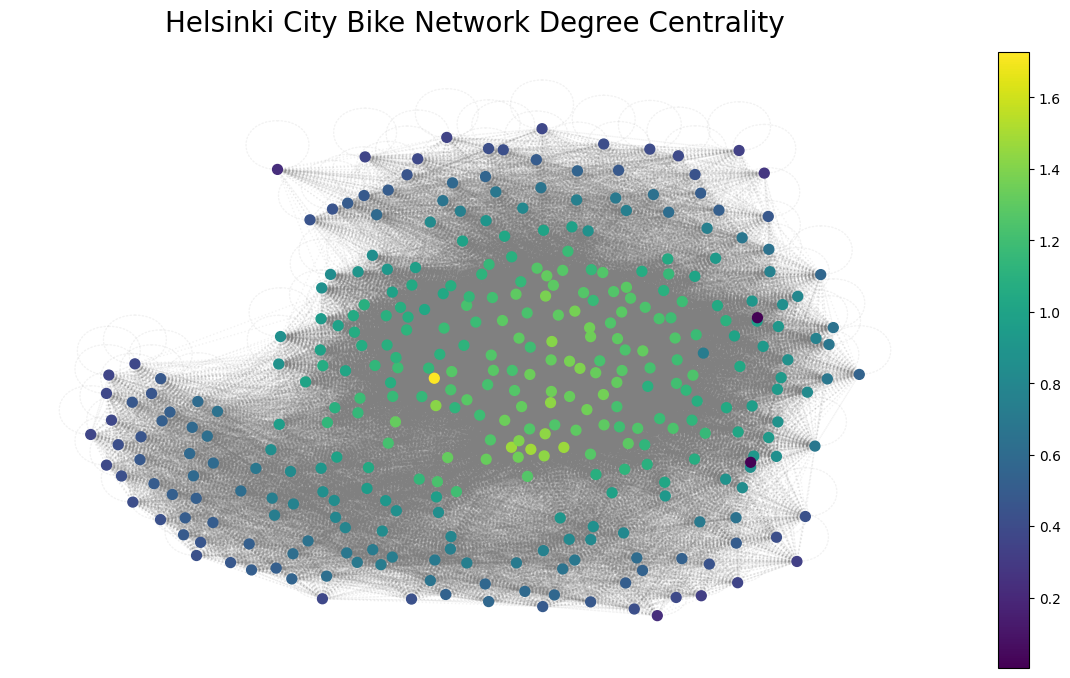

In [ ]:
# Degree Centrality
def centralityDegree(G):

    # Figure
    fig, ax = plt.subplots(figsize=(15,8))

    # Check if the graph has nodes
    if not G.nodes():
        print("Error: Graph has no nodes.")
        return

    degrees = nx.degree_centrality(G)
    node_color = [degrees[i] for i in degrees.keys()]

    # Color scale
    colors=range(20)
    cmap = plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G=G, pos=pos, node_color=node_color, cmap="viridis", alpha=1, node_size=50)
    nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Degree Centrality', fontdict={"fontsize": 20}, pad=15)
    ax.axis('off')


# function call
centralityDegree(G)


The average degree of a node in the graph is 77.78.
The stations with the highest degree centrality are:
Kalasatama (M): 0.52 centrality
Ympyrätalo: 0.50 centrality
Itämerentori: 0.47 centrality
Pasilan asema: 0.47 centrality
Messeniuksenkatu: 0.47 centrality


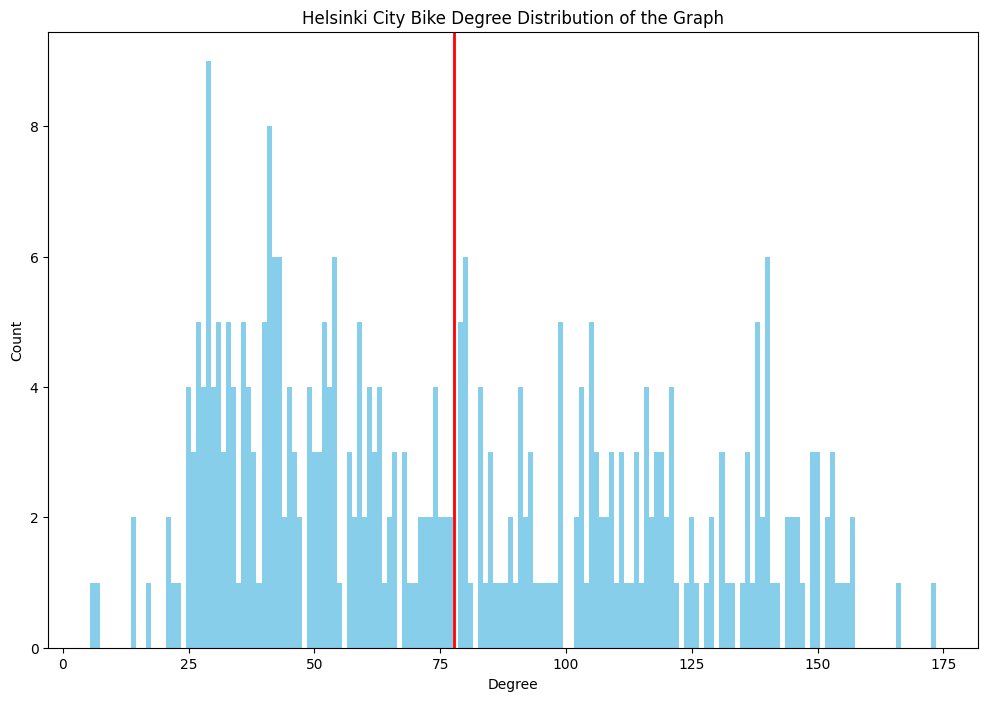

In [ ]:
# Degree distribution
def analyze_graph(G):

    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(G)

    # Calculate average degree
    average_degree = sum(dict(G.degree()).values()) / len(G)

    # Identify top stations based on degree centrality
    top_stations = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

    # Display information
    print(f"The average degree of a node in the graph is {average_degree:.2f}.")
    print("The stations with the highest degree centrality are:")
    for station, centrality in top_stations:
        print(f"{station}: {centrality:.2f} centrality")

    # Plot degree distribution
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.bar(deg, cnt, width=1, color='skyblue')
    plt.axvline(x=average_degree, color='red', linestyle='-', linewidth=2)
    plt.title("Helsinki City Bike Degree Distribution of the Graph")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.show()

analyze_graph(G)

<ipython-input-92-32ea4db9cc87>:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


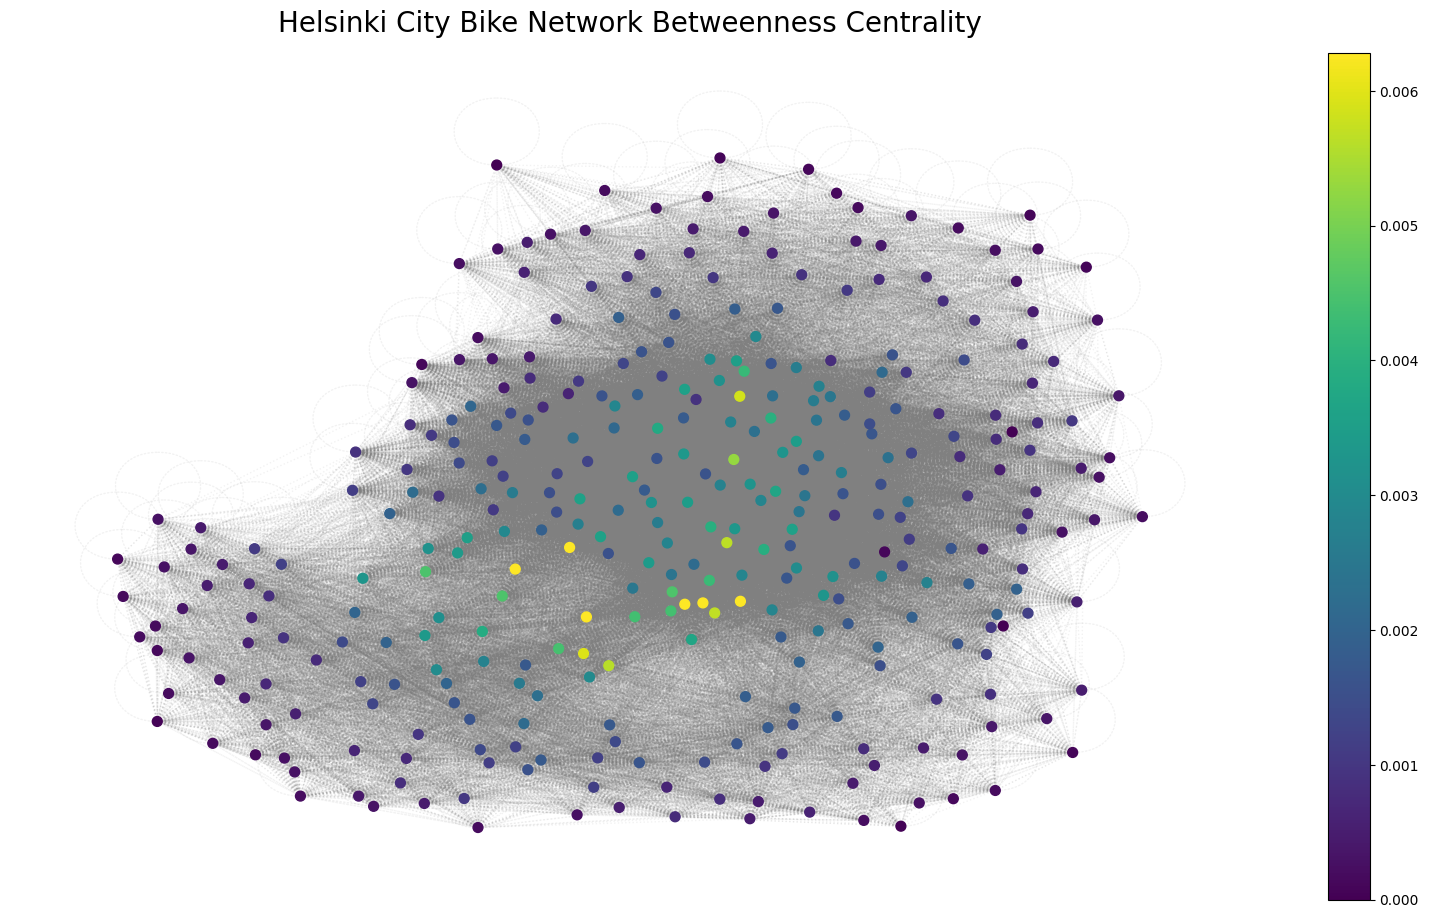

In [ ]:
# Betweenness Centrality

from mpl_toolkits.axes_grid1 import make_axes_locatable

def centralityBetweenness(Graph):

    G = Graph.copy()
    G.remove_node("Haukilahdenkatu")

    # Figure
    fig, ax = plt.subplots(figsize=(20, 11))

    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    cmap = plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Plot nodes and edges
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G=G, pos=pos, node_color=node_color, cmap="viridis", alpha=1, node_size=50, vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Betweenness Centrality', fontdict={"fontsize": 20}, pad=15)
    ax.axis('off')

    plt.show()

# call the function
centralityBetweenness(G)

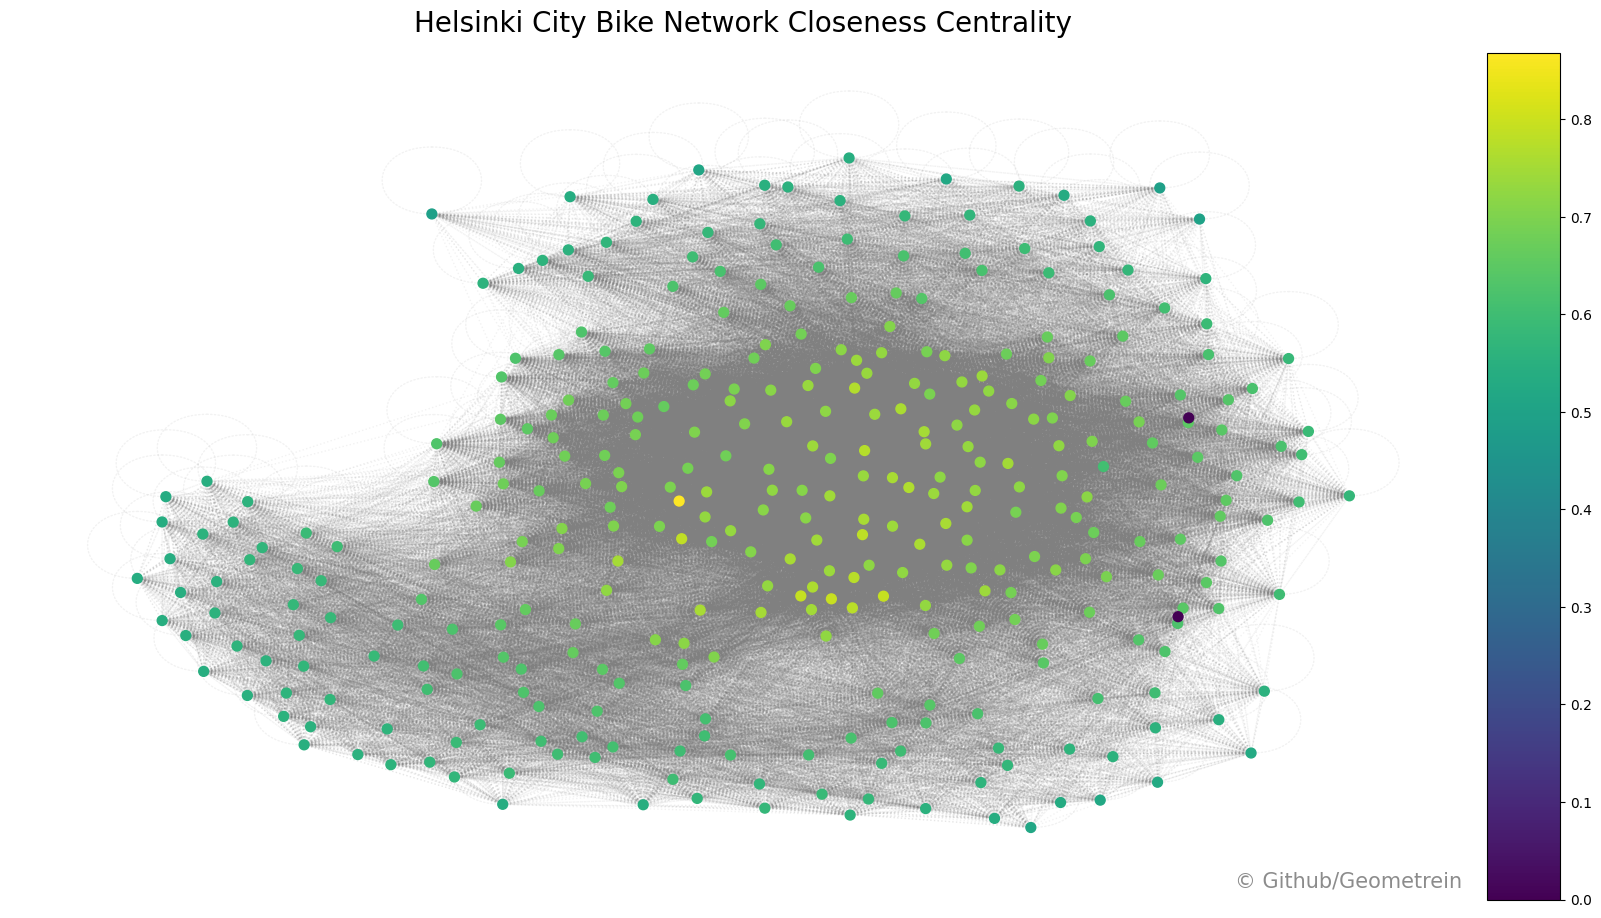

In [ ]:
# Closeness Centrality

def centralityCloseness(G):

    # Figure
    fig, ax = plt.subplots(figsize=(20, 11))

    closeness = nx.closeness_centrality(G)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    cmap = plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)

    # Explicitly set the range for the color scale
    if vmin == vmax:
        node_color = [0] * len(node_color)
        vmin = 0
        vmax = 1

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    # Plot nodes and edges
    pos = nx.kamada_kawai_layout(G)
    nodes = nx.draw_networkx_nodes(G=G, pos=pos, node_color=node_color, cmap="viridis", alpha=1, node_size=50, vmin=vmin, vmax=vmax)
    edges = nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=False)

    # Create a colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Create the colorbar using the explicit colorbar axis
    cbar = plt.colorbar(sm, cax=cax)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Closeness Centrality', fontdict={"fontsize": 20}, pad=15)
    ax.axis('off')

    # Display the colorbar explicitly
    plt.show()

# Call the function
centralityCloseness(G)

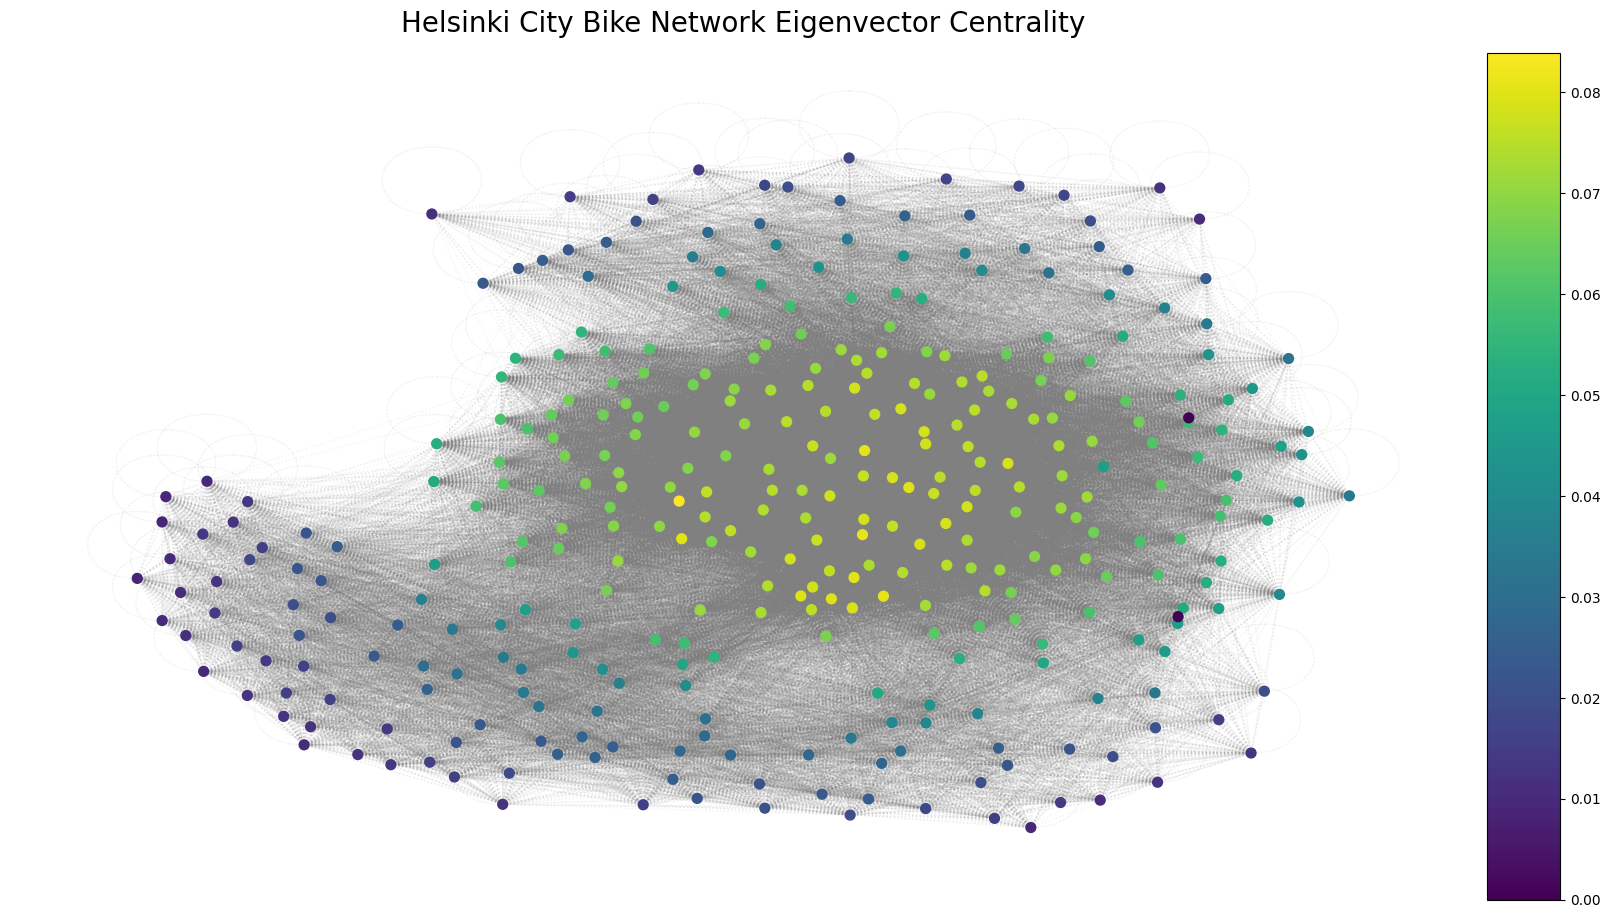

In [ ]:
# Eigenvector centrality

def centralityEigenvector(G):

    # Figure
    fig, ax = plt.subplots(figsize=(20, 11))

    eigenvector = nx.eigenvector_centrality(G, max_iter=6000, weight="duration")
    node_color = [eigenvector[i] for i in eigenvector.keys()]

    # Color scale
    cmap = plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)

    # Explicitly set the range for the color scale
    if vmin == vmax:
        node_color = [0] * len(node_color)
        vmin = 0
        vmax = 1

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    # Plot nodes and edges
    pos = nx.kamada_kawai_layout(G)
    nodes = nx.draw_networkx_nodes(G=G, pos=pos, node_color=node_color, cmap="viridis", alpha=1, node_size=50, vmin=vmin, vmax=vmax)
    edges = nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=False)

    # Create a colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Create the colorbar using the explicit colorbar axis
    cbar = plt.colorbar(sm, cax=cax)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Eigenvector Centrality', fontdict={"fontsize": 20}, pad=15)
    ax.axis('off')

    # Display the colorbar explicitly
    plt.show()

# calling the function
centralityEigenvector(G)